In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model, clone_model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import scipy.stats as stats

In [2]:
# Define paths
commercial_frames_path = "C:\\Users\\Administrator\\Desktop\\Full_data_both_channels\\full_data_adbreak"
show_frames_path = "C:\\Users\\Administrator\\Desktop\\Full_data_both_channels\\full_data_show"


In [3]:
# Parameters
image_size = (128, 128)
batch_size = 1000  # Adjust based on your memory capacity

In [4]:
# Helper function to load images from a folder in batches
def load_images_from_folder_in_batches(folder, label, image_size, batch_size):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= batch_size:
            yield np.array(images), np.array(labels)
            images, labels = [], []
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    if images:
        yield np.array(images), np.array(labels)

# Helper function to preprocess images
def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

In [5]:
# Load and preprocess a sample of data for EDA
def load_sample_data(folder, label, image_size, sample_size):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= sample_size:
            break
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [6]:
# Load a small sample for EDA
sample_size = 1000
show_sample_images, show_sample_labels = load_sample_data(show_frames_path, 0, image_size, sample_size)
commercial_sample_images, commercial_sample_labels = load_sample_data(commercial_frames_path, 1, image_size, sample_size)


In [7]:
# Combine samples
sample_images = np.concatenate((show_sample_images, commercial_sample_images), axis=0)
sample_labels = np.concatenate((show_sample_labels, commercial_sample_labels), axis=0)


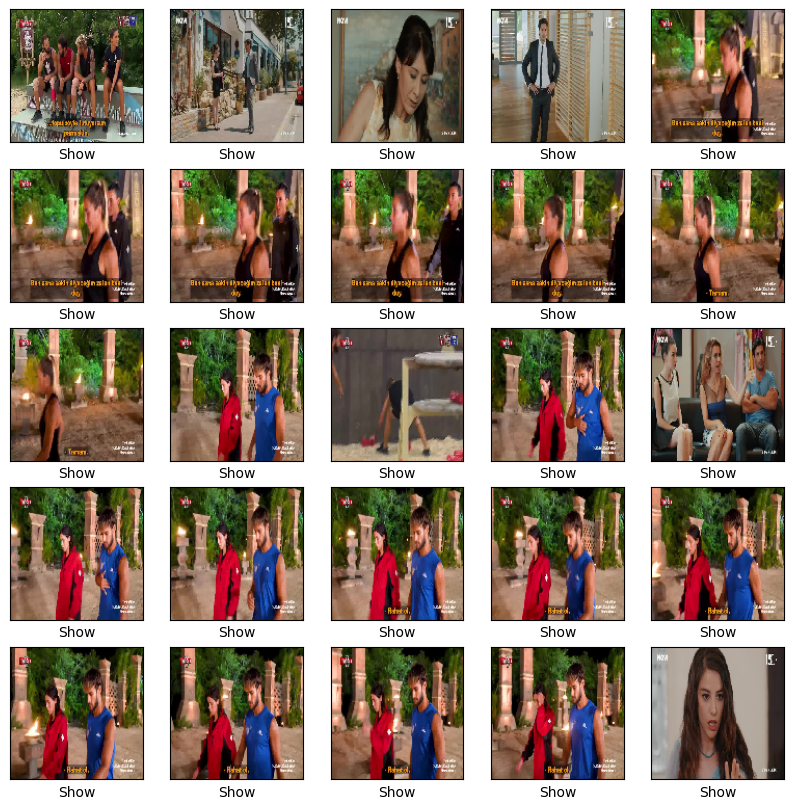

In [8]:
# EDA: Display sample images
def plot_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype('uint8'))
        plt.xlabel(class_names[labels[i]])
    plt.show()

class_names = ["Show", "Commercial"]
plot_sample_images(sample_images, sample_labels, class_names)

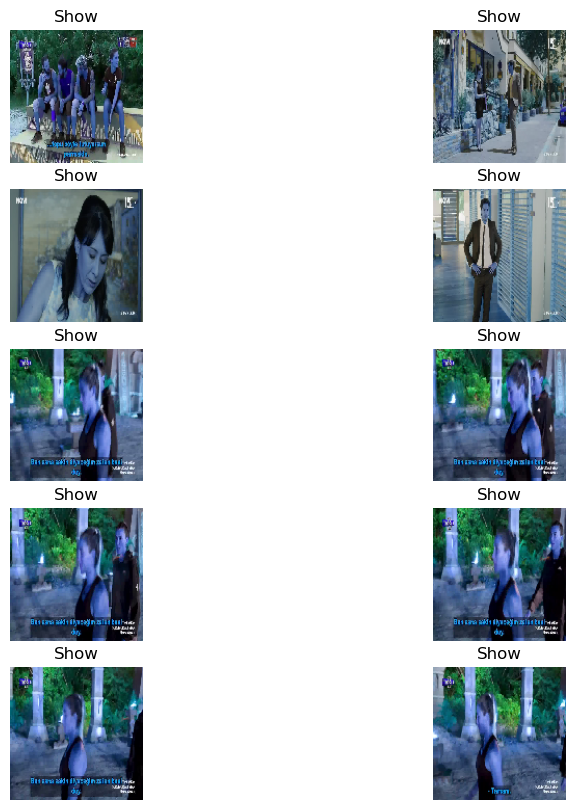

In [9]:
def display_sample_images(images, labels, sample_size=10):
    plt.figure(figsize=(10, 10))
    for i in range(sample_size):
        plt.subplot(5, 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i].astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.title("Show" if labels[i] == 0 else "Commercial")
        plt.axis('off')
    plt.show()

# Display 10 sample images
display_sample_images(sample_images, sample_labels, sample_size=10)


In [10]:
# Function to calculate descriptive statistics
def calculate_statistics(images):
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std

# Calculate statistics for show and commercial images
show_mean, show_std = calculate_statistics(show_sample_images)
commercial_mean, commercial_std = calculate_statistics(commercial_sample_images)

print("Show Images - Mean:", show_mean, "Std Dev:", show_std)
print("Commercial Images - Mean:", commercial_mean, "Std Dev:", commercial_std)


Show Images - Mean: [108.320305  91.56647   74.79465 ] Std Dev: [64.28622 57.951   56.41747]
Commercial Images - Mean: [122.81141  107.851906 104.1036  ] Std Dev: [75.31012 74.19246 74.69307]


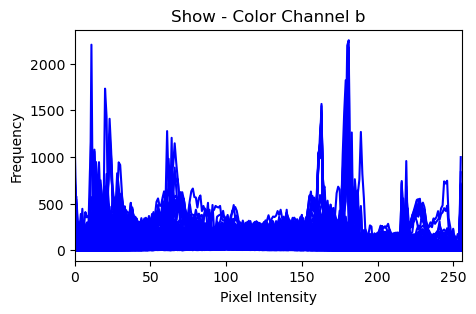

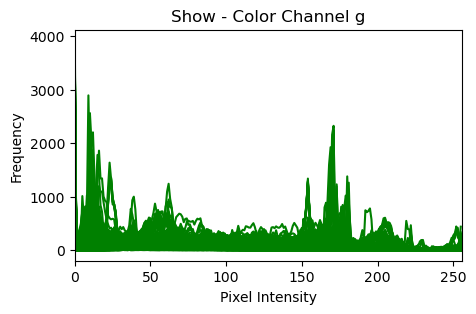

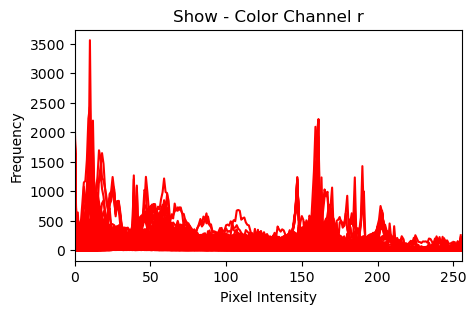

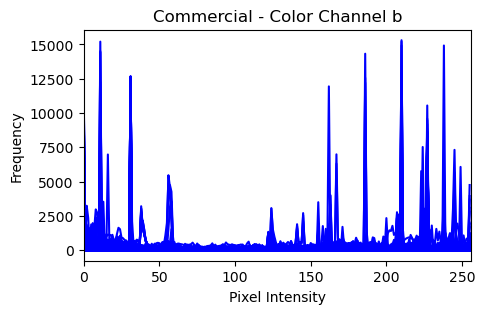

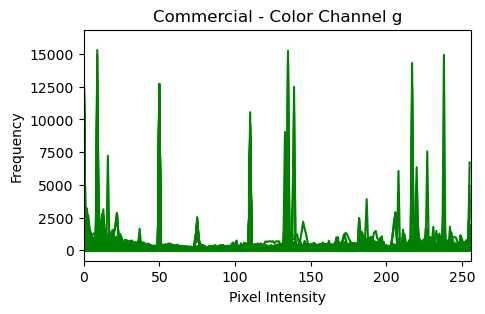

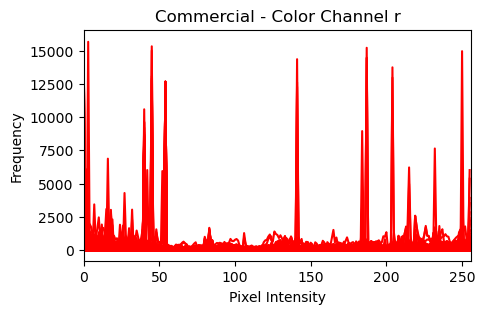

In [11]:
# Function to plot color distribution
def plot_color_distribution(images, title):
    colors = ('b', 'g', 'r')
    for i, col in enumerate(colors):
        plt.figure(figsize=(5, 3))
        for img in images:
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            plt.plot(hist, color=col)
            plt.xlim([0, 256])
        plt.title(f'{title} - Color Channel {col}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()

# Plot color distribution for show and commercial images
plot_color_distribution(show_sample_images, 'Show')
plot_color_distribution(commercial_sample_images, 'Commercial')


Processing image 0 with shape: (128, 128, 3) and dtype: float32
Processing image 1 with shape: (128, 128, 3) and dtype: float32
Processing image 2 with shape: (128, 128, 3) and dtype: float32
Processing image 3 with shape: (128, 128, 3) and dtype: float32
Processing image 4 with shape: (128, 128, 3) and dtype: float32
Processing image 5 with shape: (128, 128, 3) and dtype: float32
Processing image 6 with shape: (128, 128, 3) and dtype: float32
Processing image 7 with shape: (128, 128, 3) and dtype: float32
Processing image 8 with shape: (128, 128, 3) and dtype: float32
Processing image 9 with shape: (128, 128, 3) and dtype: float32
Processing image 10 with shape: (128, 128, 3) and dtype: float32
Processing image 11 with shape: (128, 128, 3) and dtype: float32
Processing image 12 with shape: (128, 128, 3) and dtype: float32
Processing image 13 with shape: (128, 128, 3) and dtype: float32
Processing image 14 with shape: (128, 128, 3) and dtype: float32
Processing image 15 with shape: (12

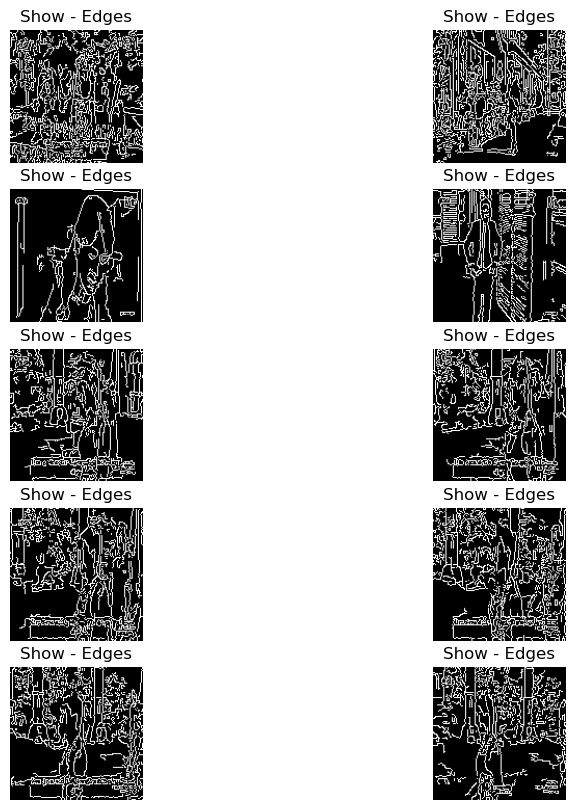

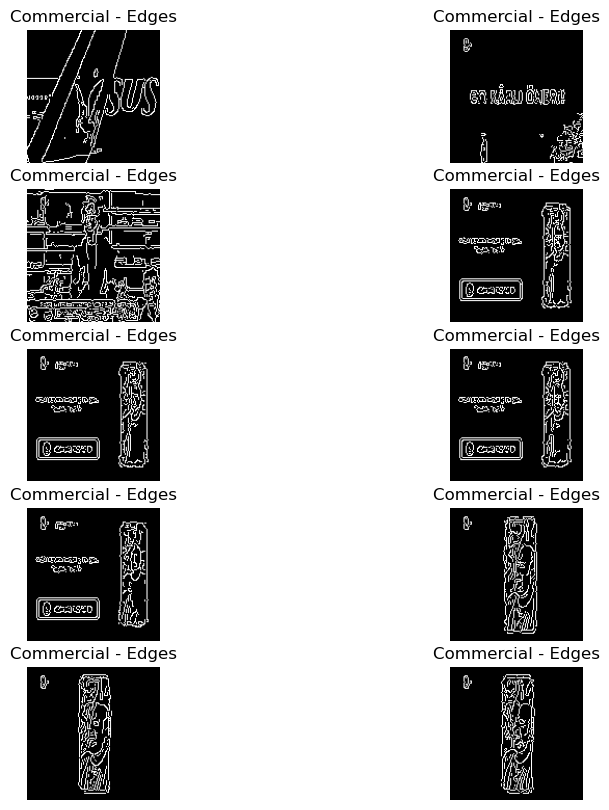

In [12]:
# Function to detect edges
def detect_edges(images):
    edges = []
    for i, image in enumerate(images):
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            print(f"Processing image {i} with shape: {image.shape} and dtype: {image.dtype}")
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            edge = cv2.Canny(gray_image, 100, 200)
            edges.append(edge)
        else:
            print(f"Skipping image {i}, invalid format: {type(image)}, shape: {image.shape if isinstance(image, np.ndarray) else 'N/A'}")
    return edges

# Display edge detected images
def display_edges(images, labels, sample_size=10):
    plt.figure(figsize=(10, 10))
    for i in range(min(sample_size, len(images))):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Show - Edges" if labels[i] == 0 else "Commercial - Edges")
        plt.axis('off')
    plt.show()

# Detect edges in show and commercial images
show_edges = detect_edges(show_sample_images)
commercial_edges = detect_edges(commercial_sample_images)

# Display edge detected images
display_edges(show_edges, [0]*len(show_edges))
display_edges(commercial_edges, [1]*len(commercial_edges))

Show Images - Brightness: 90.59645 Contrast: 49.869366
Commercial Images - Brightness: 109.795616 Contrast: 53.839745


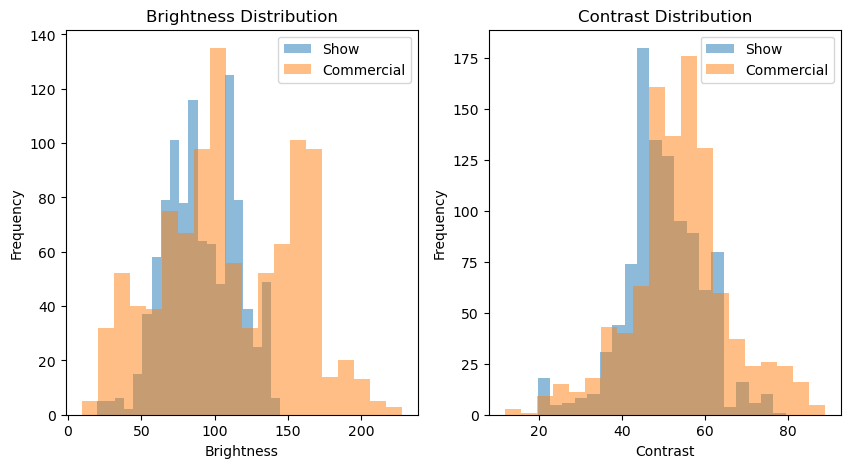

In [13]:
# Function to calculate brightness and contrast
def calculate_brightness_contrast(images):
    brightness = [np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in images]
    contrast = [np.std(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in images]
    return brightness, contrast

# Calculate brightness and contrast for show and commercial images
show_brightness, show_contrast = calculate_brightness_contrast(show_sample_images)
commercial_brightness, commercial_contrast = calculate_brightness_contrast(commercial_sample_images)

print("Show Images - Brightness:", np.mean(show_brightness), "Contrast:", np.mean(show_contrast))
print("Commercial Images - Brightness:", np.mean(commercial_brightness), "Contrast:", np.mean(commercial_contrast))

# Plot brightness and contrast
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(show_brightness, bins=20, alpha=0.5, label='Show')
plt.hist(commercial_brightness, bins=20, alpha=0.5, label='Commercial')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(show_contrast, bins=20, alpha=0.5, label='Show')
plt.hist(commercial_contrast, bins=20, alpha=0.5, label='Commercial')
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [14]:
# Function to compute color histograms
def compute_color_histograms(images):
    histograms = []
    for image in images:
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
            hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])
            histograms.append((hist_b, hist_g, hist_r))
    return histograms

# Function to plot color histograms
def plot_color_histograms(histograms, labels, sample_size=10):
    plt.figure(figsize=(15, 5))
    for i in range(min(sample_size, len(histograms))):
        hist_b, hist_g, hist_r = histograms[i]
        plt.subplot(sample_size, 3, i*3 + 1)
        plt.plot(hist_b, color='b')
        plt.xlim([0, 256])
        plt.subplot(sample_size, 3, i*3 + 2)
        plt.plot(hist_g, color='g')
        plt.xlim([0, 256])
        plt.subplot(sample_size, 3, i*3 + 3)
        plt.plot(hist_r, color='r')
        plt.xlim([0, 256])
        plt.title("Show" if labels[i] == 0 else "Commercial")
    plt.show()


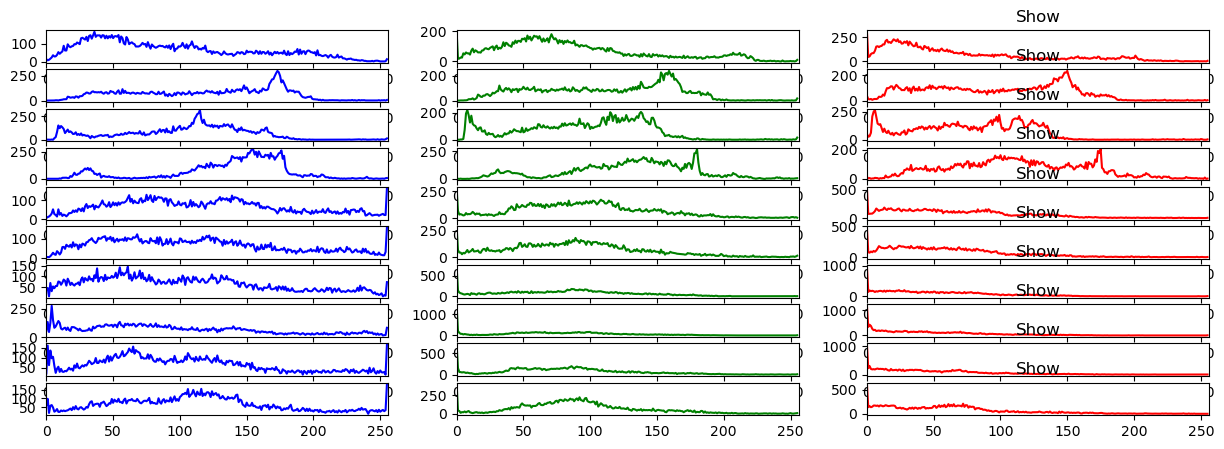

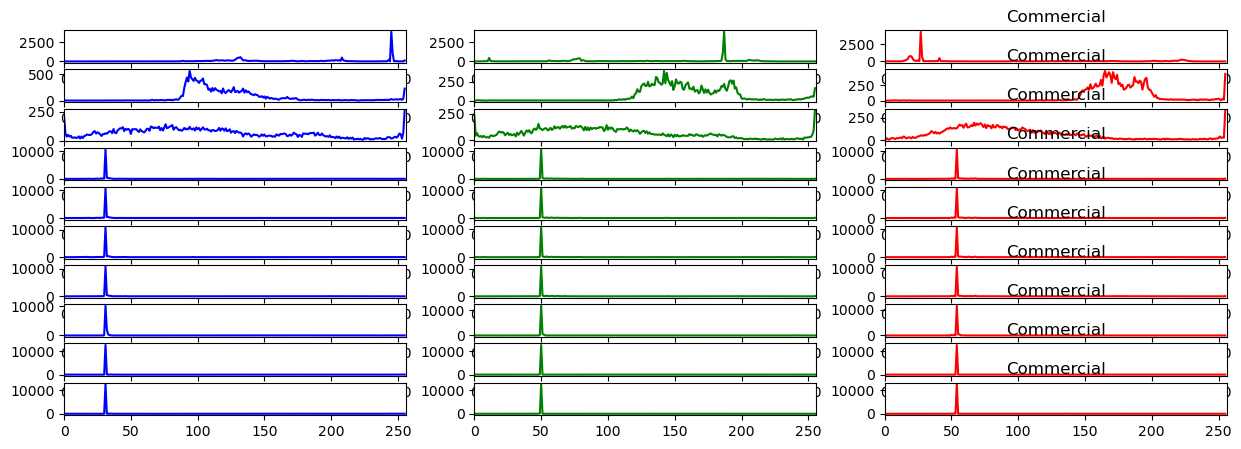

In [15]:
# Compute color histograms
show_histograms = compute_color_histograms(show_sample_images)
commercial_histograms = compute_color_histograms(commercial_sample_images)

# Plot color histograms
plot_color_histograms(show_histograms, [0]*len(show_histograms))
plot_color_histograms(commercial_histograms, [1]*len(commercial_histograms))

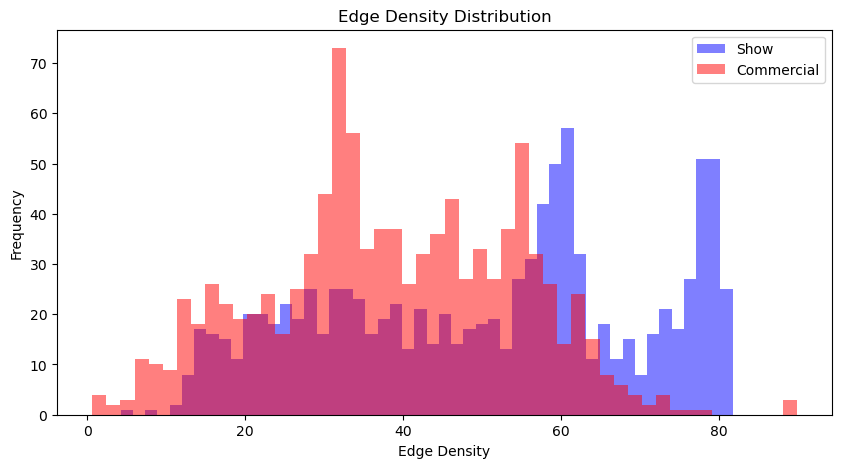

In [16]:
# Function to compute edge density
def compute_edge_density(edges):
    densities = []
    for edge in edges:
        density = np.sum(edge) / edge.size
        densities.append(density)
    return densities

# Compute edge densities
show_edge_density = compute_edge_density(show_edges)
commercial_edge_density = compute_edge_density(commercial_edges)

# Plot edge density distribution
plt.figure(figsize=(10, 5))
plt.hist(show_edge_density, bins=50, alpha=0.5, label='Show', color='blue')
plt.hist(commercial_edge_density, bins=50, alpha=0.5, label='Commercial', color='red')
plt.xlabel('Edge Density')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Edge Density Distribution')
plt.show()


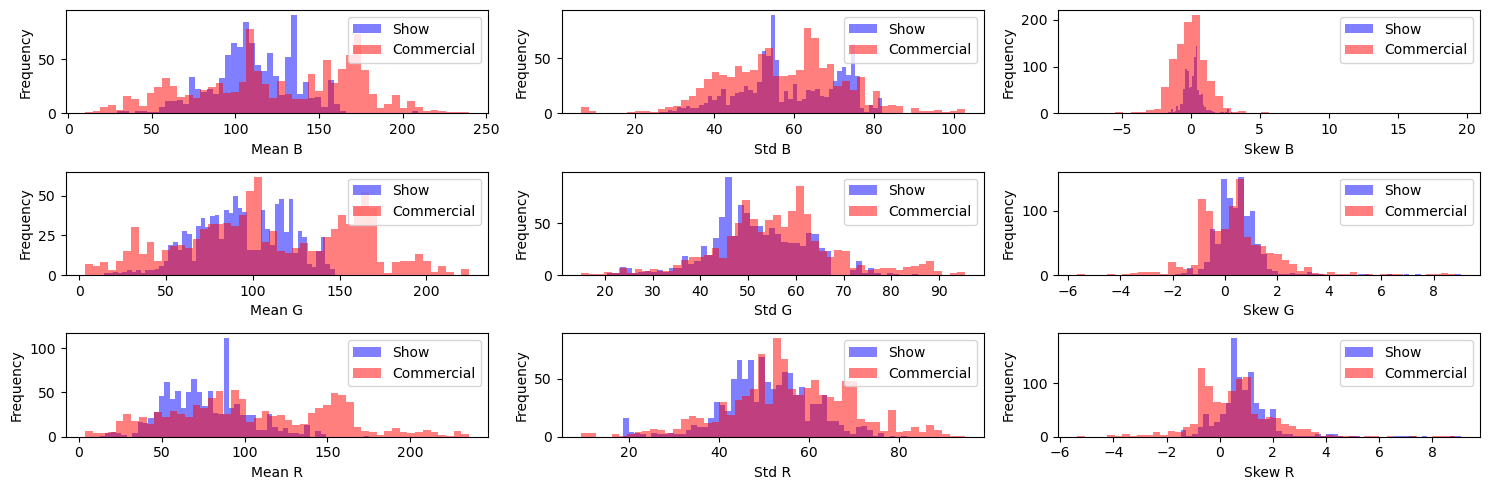

In [17]:
import scipy.stats as stats

# Function to compute color moments
def compute_color_moments(images):
    moments = []
    for image in images:
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            mean_b = np.mean(image[:, :, 0])
            std_b = np.std(image[:, :, 0])
            skew_b = stats.skew(image[:, :, 0].reshape(-1))
            
            mean_g = np.mean(image[:, :, 1])
            std_g = np.std(image[:, :, 1])
            skew_g = stats.skew(image[:, :, 1].reshape(-1))
            
            mean_r = np.mean(image[:, :, 2])
            std_r = np.std(image[:, :, 2])
            skew_r = stats.skew(image[:, :, 2].reshape(-1))
            
            moments.append([mean_b, std_b, skew_b, mean_g, std_g, skew_g, mean_r, std_r, skew_r])
    return np.array(moments)

# Compute color moments
show_color_moments = compute_color_moments(show_sample_images)
commercial_color_moments = compute_color_moments(commercial_sample_images)

# Plot color moments
plt.figure(figsize=(15, 5))
labels = ['Mean B', 'Std B', 'Skew B', 'Mean G', 'Std G', 'Skew G', 'Mean R', 'Std R', 'Skew R']
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.hist(show_color_moments[:, i], bins=50, alpha=0.5, label='Show', color='blue')
    plt.hist(commercial_color_moments[:, i], bins=50, alpha=0.5, label='Commercial', color='red')
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


C:\Users\Administrator\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


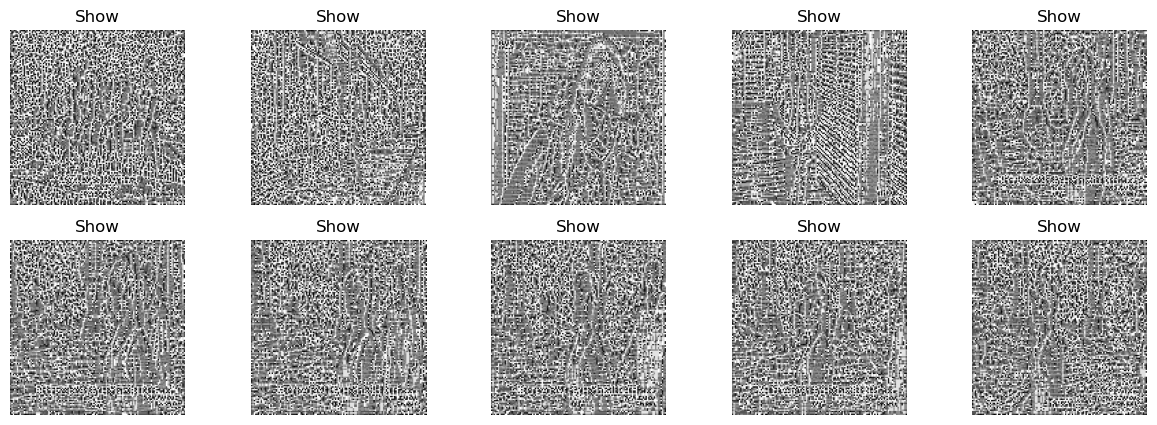

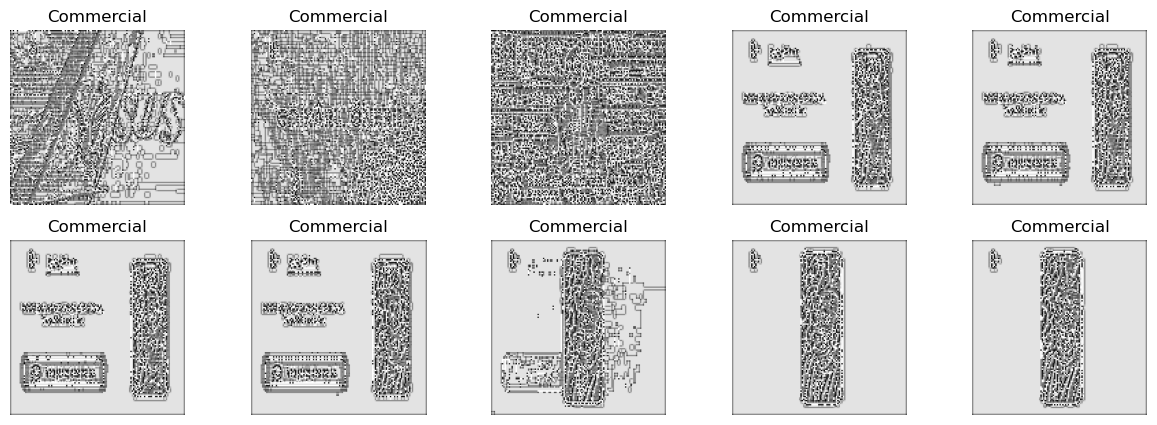

In [18]:
from skimage.feature import local_binary_pattern

# Function to compute LBP
def compute_lbp(images):
    lbps = []
    for image in images:
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
            lbps.append(lbp)
    return lbps

# Compute LBP
show_lbp = compute_lbp(show_sample_images)
commercial_lbp = compute_lbp(commercial_sample_images)

# Plot LBP
def plot_lbp(lbps, labels, sample_size=10):
    plt.figure(figsize=(15, 5))
    for i in range(min(sample_size, len(lbps))):
        plt.subplot(2, sample_size//2, i+1)
        plt.imshow(lbps[i], cmap='gray')
        plt.title("Show" if labels[i] == 0 else "Commercial")
        plt.axis('off')
    plt.show()

plot_lbp(show_lbp, [0]*len(show_lbp))
plot_lbp(commercial_lbp, [1]*len(commercial_lbp))


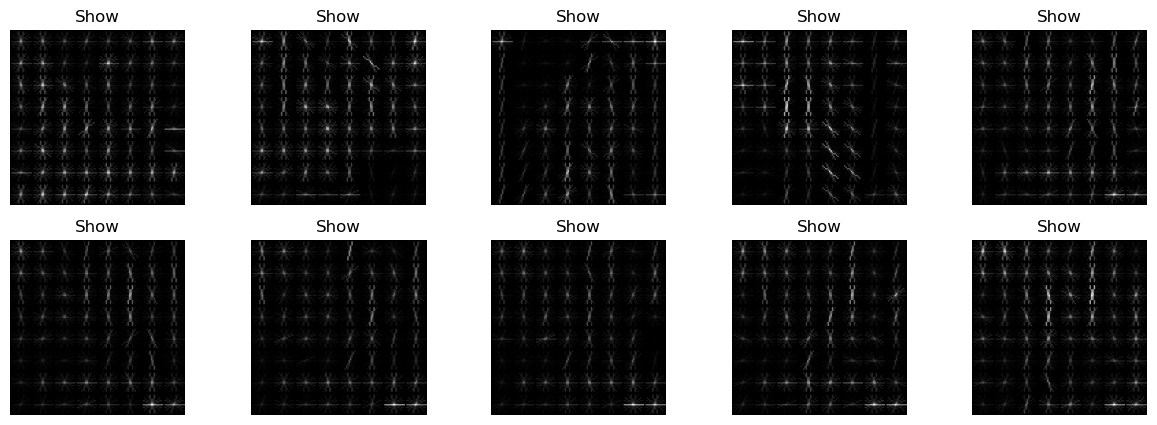

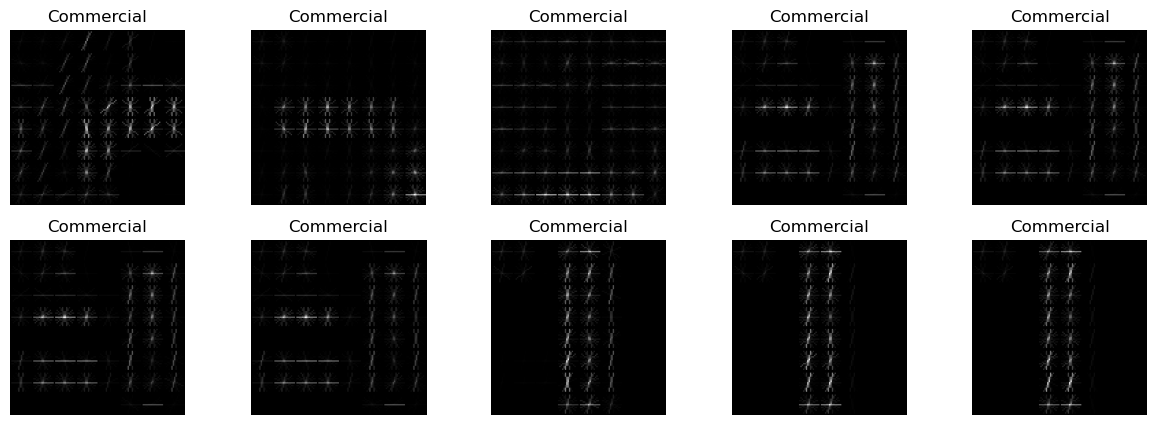

In [19]:
from skimage.feature import hog

# Function to compute HOG
def compute_hog(images):
    hogs = []
    for image in images:
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            hog_features, hog_image = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
            hogs.append(hog_image)
    return hogs

# Compute HOG
show_hog = compute_hog(show_sample_images)
commercial_hog = compute_hog(commercial_sample_images)

# Plot HOG
def plot_hog(hogs, labels, sample_size=10):
    plt.figure(figsize=(15, 5))
    for i in range(min(sample_size, len(hogs))):
        plt.subplot(2, sample_size//2, i+1)
        plt.imshow(hogs[i], cmap='gray')
        plt.title("Show" if labels[i] == 0 else "Commercial")
        plt.axis('off')
    plt.show()

plot_hog(show_hog, [0]*len(show_hog))
plot_hog(commercial_hog, [1]*len(commercial_hog))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

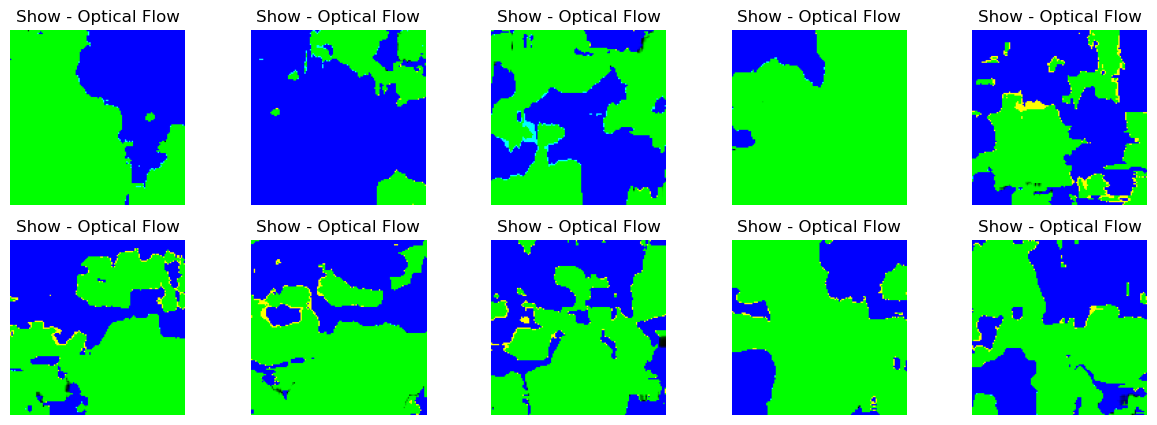

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

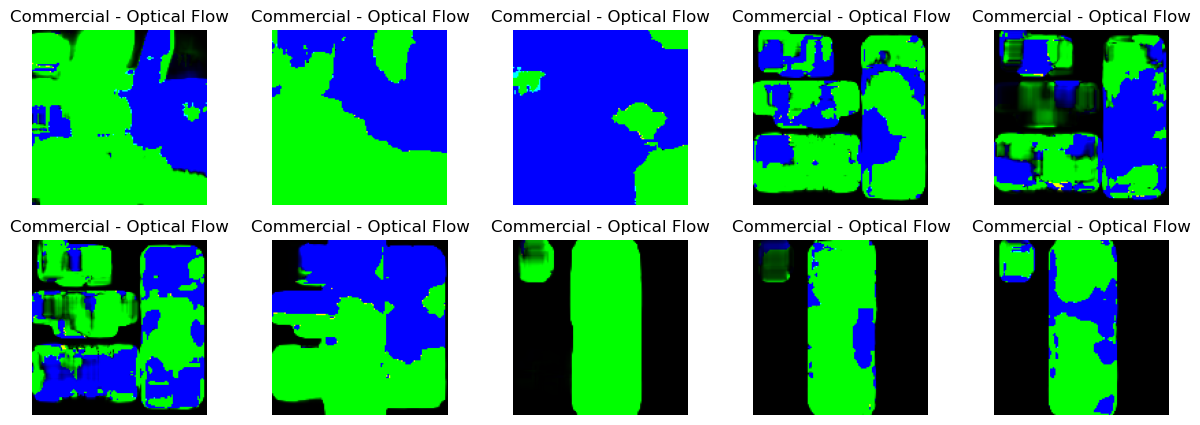

In [20]:
# Load consecutive frames from a directory
def load_consecutive_frames(folder, image_size, num_pairs):
    image_pairs = []
    files = sorted(os.listdir(folder))  # Ensure files are sorted
    for i in range(min(len(files) - 1, num_pairs)):
        img_path1 = os.path.join(folder, files[i])
        img_path2 = os.path.join(folder, files[i + 1])
        img1 = load_img(img_path1, target_size=image_size)
        img2 = load_img(img_path2, target_size=image_size)
        img_array1 = img_to_array(img1)
        img_array2 = img_to_array(img2)
        image_pairs.append((img_array1, img_array2))
    return image_pairs

# Compute optical flow using Farneback's method
def compute_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Load consecutive frames
show_pairs = load_consecutive_frames(show_frames_path, image_size, num_pairs=10)
commercial_pairs = load_consecutive_frames(commercial_frames_path, image_size, num_pairs=10)

# Compute optical flow for each pair
show_flows = [compute_optical_flow(pair[0], pair[1]) for pair in show_pairs]
commercial_flows = [compute_optical_flow(pair[0], pair[1]) for pair in commercial_pairs]

# Display optical flow
def display_optical_flow(flows, title):
    plt.figure(figsize=(15, 5))
    for i, flow in enumerate(flows):
        plt.subplot(2, len(flows)//2, i+1)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv = np.zeros_like(show_pairs[0][0])
        hsv[..., 1] = 255
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        plt.imshow(rgb_flow)
        plt.title(title)
        plt.axis('off')
    plt.show()

display_optical_flow(show_flows, 'Show - Optical Flow')
display_optical_flow(commercial_flows, 'Commercial - Optical Flow')

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)


In [22]:
# Function to preprocess a single image
def preprocess_image(image):
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)

# Function to preprocess a batch of images
def preprocess_images(images):
    preprocessed = [preprocess_image(img) for img in images]
    return np.vstack(preprocessed)


In [23]:
# Function to extract features in batches
def extract_features_in_batches(model, images, batch_size=32):
    num_images = len(images)
    features = []
    
    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch_images = images[start:end]
        batch_images_preprocessed = preprocess_images(batch_images)
        batch_features = model.predict(batch_images_preprocessed)
        features.append(batch_features)
        
    return np.vstack(features)

# Assuming show_sample_images and commercial_sample_images are already loaded

# Extract features
show_features = extract_features_in_batches(model, show_sample_images)
commercial_features = extract_features_in_batches(model, commercial_sample_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

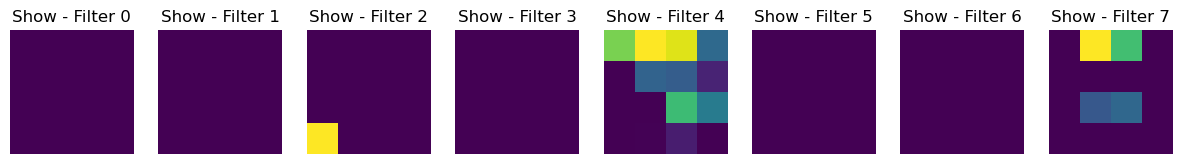

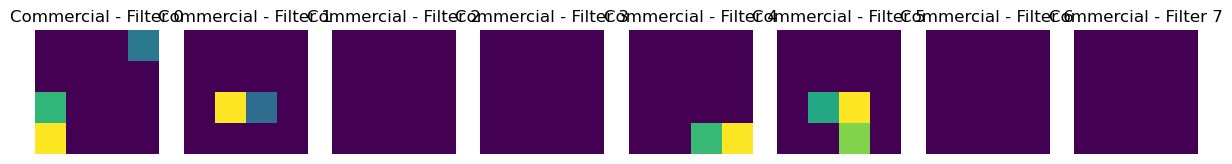

In [24]:
import matplotlib.pyplot as plt

# Function to plot feature maps
def plot_feature_maps(features, title):
    plt.figure(figsize=(15, 5))
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(features[0, :, :, i], cmap='viridis')
        plt.title(f'{title} - Filter {i}')
        plt.axis('off')
    plt.show()

# Plot feature maps
plot_feature_maps(show_features, 'Show')
plot_feature_maps(commercial_features, 'Commercial')


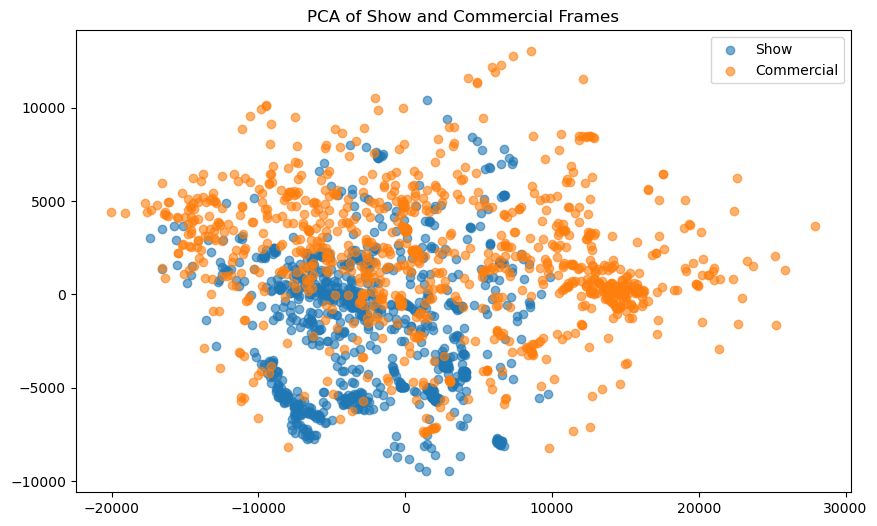

In [25]:
from sklearn.decomposition import PCA

# Flatten images for PCA
show_flatten = [img.flatten() for img in show_sample_images]
commercial_flatten = [img.flatten() for img in commercial_sample_images]

# Combine and fit PCA
combined_flatten = show_flatten + commercial_flatten
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_flatten)

# Separate PCA results
show_pca = pca_result[:len(show_sample_images)]
commercial_pca = pca_result[len(show_sample_images):]

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(show_pca[:, 0], show_pca[:, 1], label='Show', alpha=0.6)
plt.scatter(commercial_pca[:, 0], commercial_pca[:, 1], label='Commercial', alpha=0.6)
plt.title('PCA of Show and Commercial Frames')
plt.legend()
plt.show()


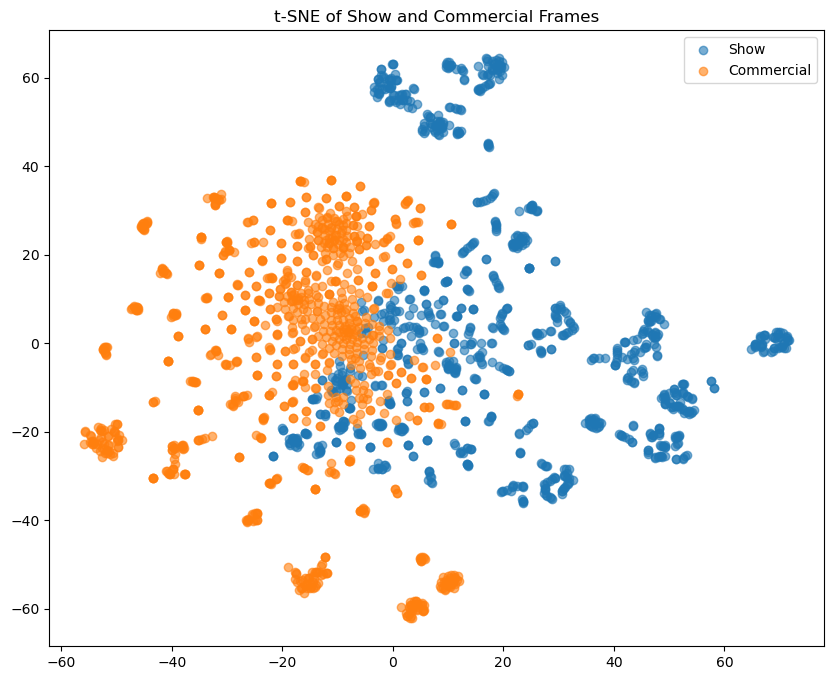

In [26]:
from sklearn.manifold import TSNE

# Flatten the features for t-SNE
show_flatten = show_features.reshape(show_features.shape[0], -1)
commercial_flatten = commercial_features.reshape(commercial_features.shape[0], -1)

# Combine the features
combined_flatten = np.concatenate((show_flatten, commercial_flatten), axis=0)

# Fit and transform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_flatten)

# Separate t-SNE results
show_tsne = tsne_result[:len(show_sample_images)]
commercial_tsne = tsne_result[len(show_sample_images):]

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(show_tsne[:, 0], show_tsne[:, 1], label='Show', alpha=0.6)
plt.scatter(commercial_tsne[:, 0], commercial_tsne[:, 1], label='Commercial', alpha=0.6)
plt.title('t-SNE of Show and Commercial Frames')
plt.legend()
plt.show()


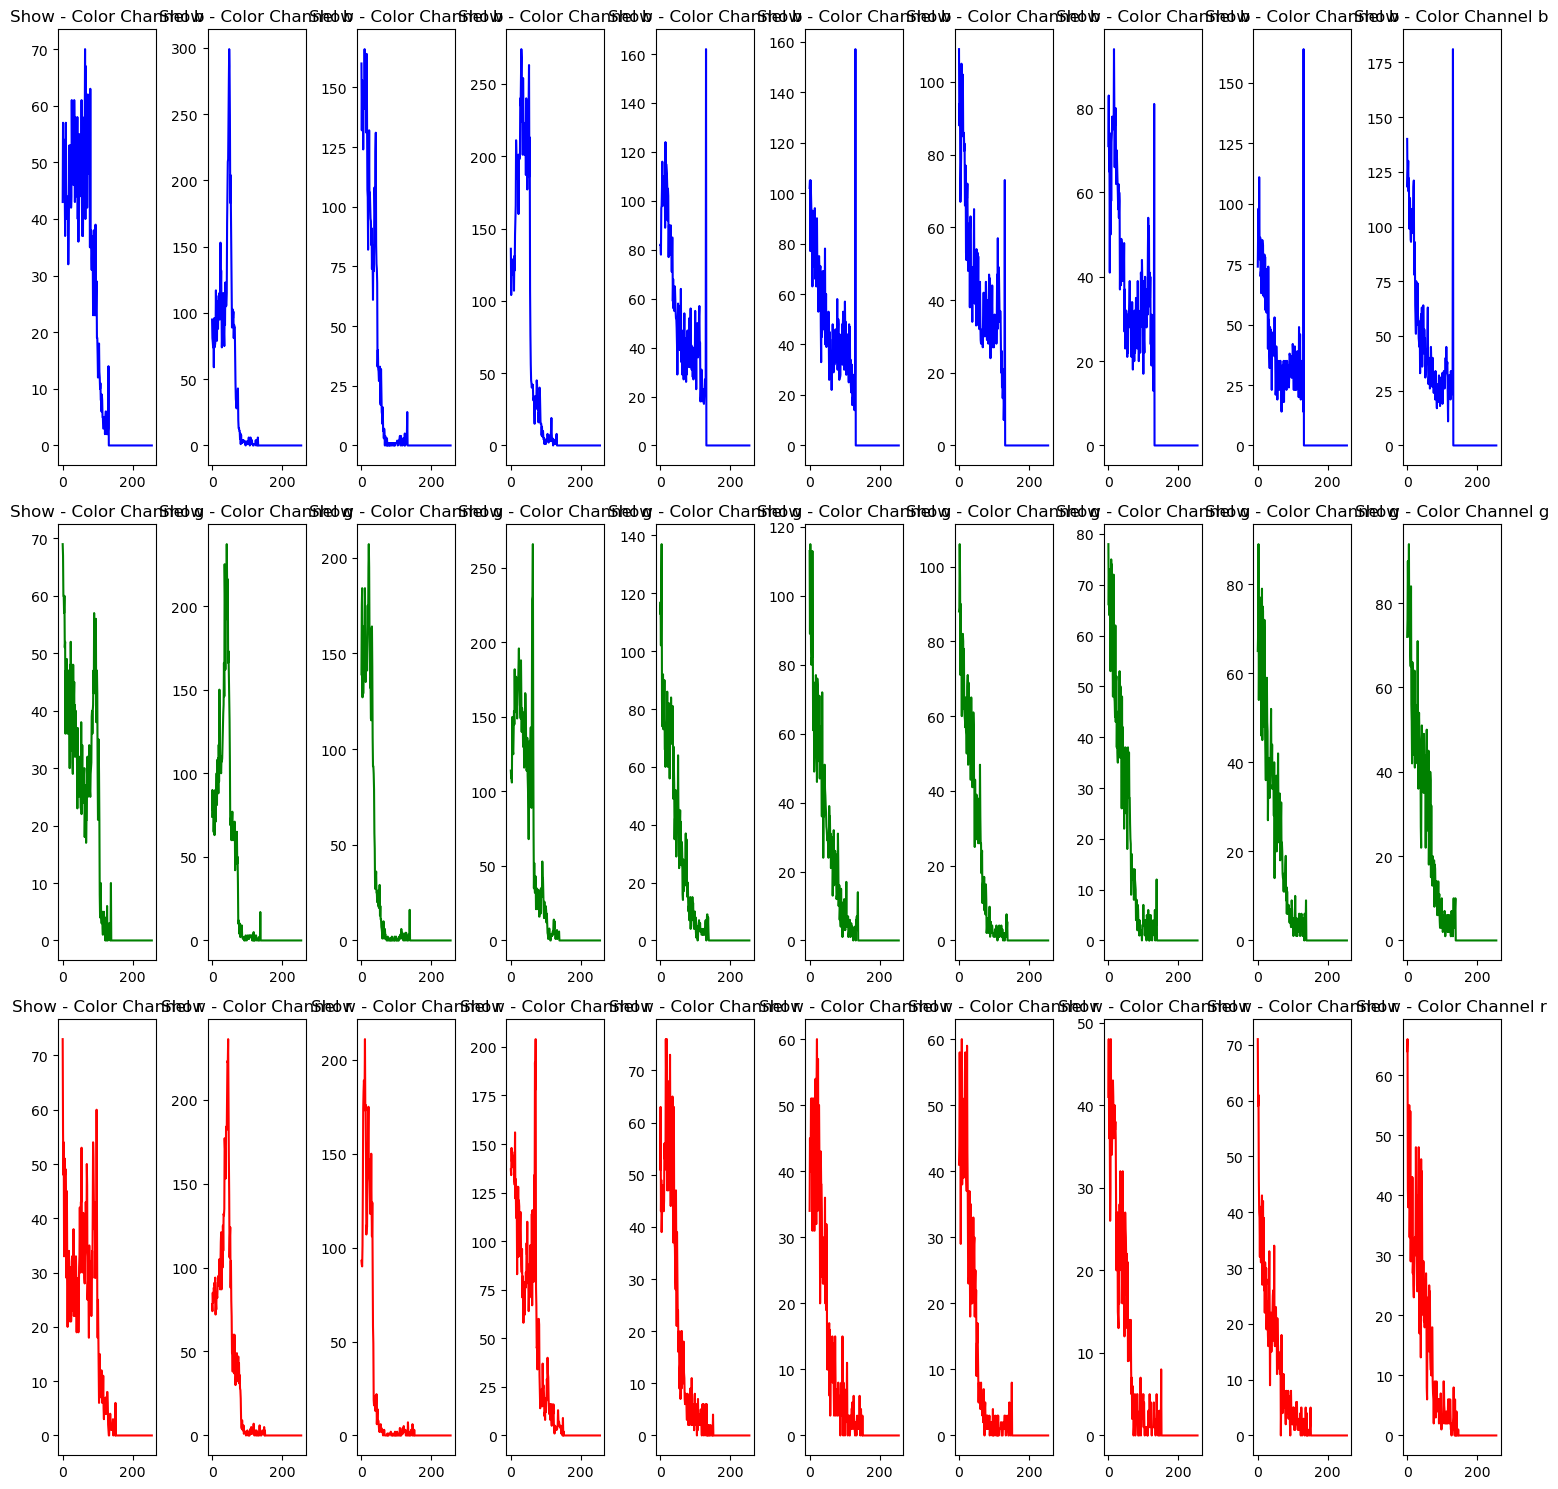

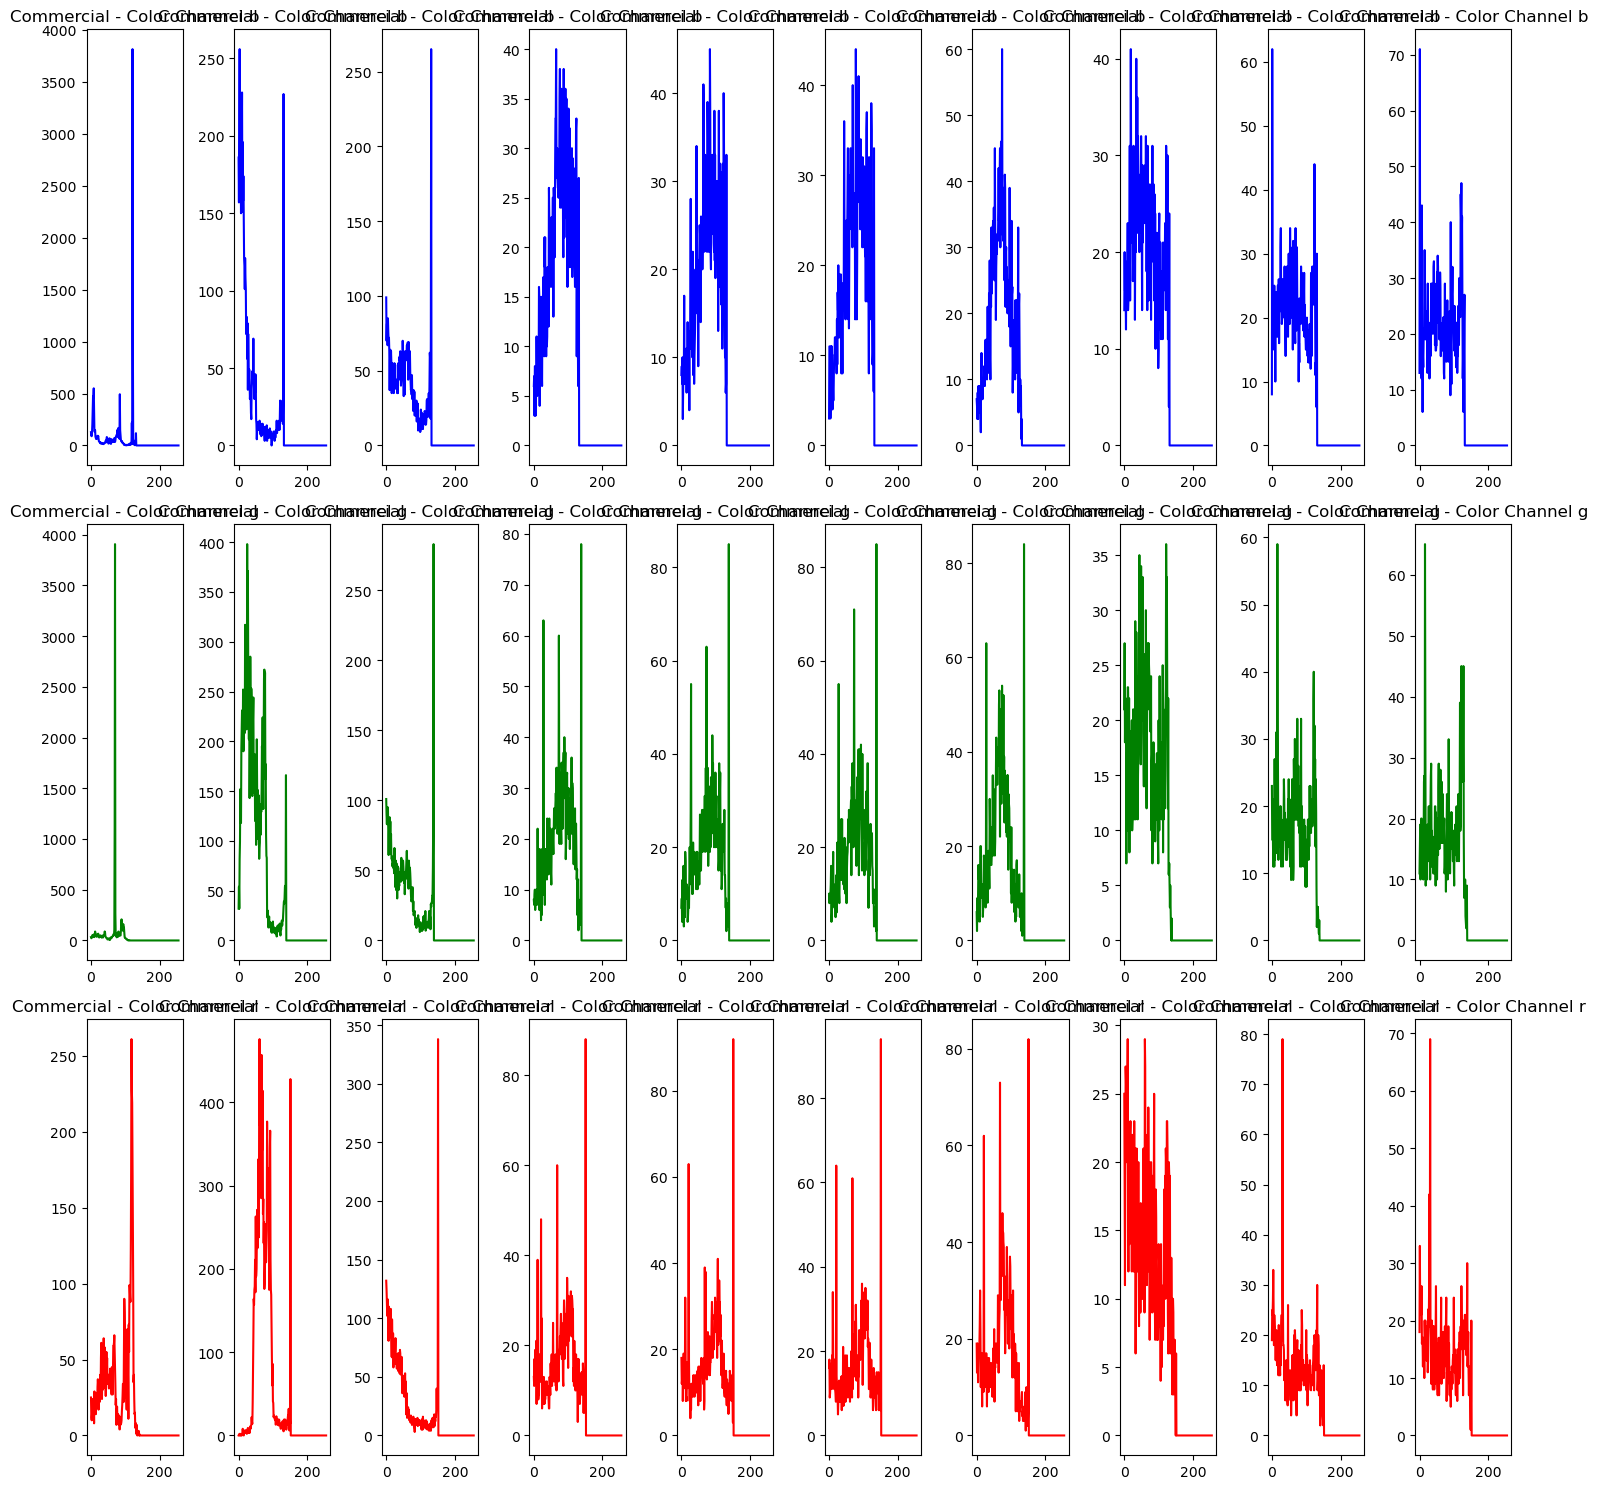

Show Histogram Moments:


Mean B        Std B       Skew B       Mean G        Std G  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     27.671312    43.452864     1.758626    22.247980    39.180428   
std      11.356691    27.378748     1.491864    11.752575    28.658913   
min       0.632812     1.999619     0.226004     0.468750     0.874442   
25%      19.674805    26.328961     0.805375    13.394531    19.310204   
50%      26.164062    36.633963     1.381525    19.902344    31.105242   
75%      38.643555    53.978893     2.122637    33.502930    54.006135   
max      59.714844   217.068054    14.194106    52.906250   214.840179   

            Skew G       Mean R        Std R       Skew R  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      2.098872    18.554562    31.885259     2.081096  
std       1.343735    10.932890    27.343899     1.326481  
min       0.592276     0.570312     1.048361     0.121340  
25%       1.284633    11.427734    15.671934     1.228388  
50%       1.803659    16.486328    24.192417     1.764617  
75%       2.417173    22.360352    35.763924     2.432866  
max      10.844649    58.671875   202.412491    10.459233

Commercial Histogram Moments:


Mean B        Std B       Skew B       Mean G        Std G  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     34.197645    77.973381     3.414318    29.910496    60.184749   
std      18.508750   118.100707     3.984504    18.705522    93.644331   
min       0.140625     0.425548     0.103096     0.234375     0.701387   
25%      19.041992    28.133315     1.193120    13.530273    23.368940   
50%      32.636719    50.331953     1.973416    24.998047    40.029362   
75%      52.345703    85.546444     3.142319    49.350586    66.992397   
max      64.000000   954.833618    15.903591    63.996094   950.793457   

            Skew G       Mean R        Std R       Skew R  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      3.239886    29.900883    58.033343     3.072730  
std       3.439764    18.779583    94.287455     3.121417  
min       0.188802     0.167969     0.449728     0.107451  
25%       1.282088    14.212891    21.115341     1.206212  
50%       1.952333    24.779297    37.702703     2.025188  
75%       3.134931    48.207031    62.532990     3.302372  
max      15.903959    64.000000   948.521057    15.904440

In [27]:
# Function to compute color histograms
def compute_color_histograms(images):
    histograms = []
    for image in images:
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
            hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])
            histograms.append((hist_b, hist_g, hist_r))
    return histograms

# Function to compute histogram moments
def compute_histogram_moments(histograms):
    moments = []
    for hist_b, hist_g, hist_r in histograms:
        mean_b = np.mean(hist_b)
        std_b = np.std(hist_b)
        skew_b = stats.skew(hist_b.ravel())
        
        mean_g = np.mean(hist_g)
        std_g = np.std(hist_g)
        skew_g = stats.skew(hist_g.ravel())
        
        mean_r = np.mean(hist_r)
        std_r = np.std(hist_r)
        skew_r = stats.skew(hist_r.ravel())
        
        moments.append([mean_b, std_b, skew_b, mean_g, std_g, skew_g, mean_r, std_r, skew_r])
    return np.array(moments)

# Compute histograms for both show and commercial images
show_histograms = compute_color_histograms(show_sample_images)
commercial_histograms = compute_color_histograms(commercial_sample_images)

# Compute histogram moments
show_histogram_moments = compute_histogram_moments(show_histograms)
commercial_histogram_moments = compute_histogram_moments(commercial_histograms)

# Visualize the histograms for a sample of images
def plot_color_histograms(histograms, labels, sample_size=10):
    plt.figure(figsize=(15, 15))
    for i in range(min(sample_size, len(histograms))):
        plt.subplot(3, sample_size, i + 1)
        plt.plot(histograms[i][0], color='b')
        plt.title(f'{labels[i]} - Color Channel b')
        plt.subplot(3, sample_size, i + 1 + sample_size)
        plt.plot(histograms[i][1], color='g')
        plt.title(f'{labels[i]} - Color Channel g')
        plt.subplot(3, sample_size, i + 1 + 2 * sample_size)
        plt.plot(histograms[i][2], color='r')
        plt.title(f'{labels[i]} - Color Channel r')
    plt.tight_layout()
    plt.show()

plot_color_histograms(show_histograms, ["Show"] * len(show_histograms))
plot_color_histograms(commercial_histograms, ["Commercial"] * len(commercial_histograms))

# Display histogram moments
import pandas as pd

show_histogram_moments_df = pd.DataFrame(show_histogram_moments, columns=[
    'Mean B', 'Std B', 'Skew B', 'Mean G', 'Std G', 'Skew G', 'Mean R', 'Std R', 'Skew R'])
commercial_histogram_moments_df = pd.DataFrame(commercial_histogram_moments, columns=[
    'Mean B', 'Std B', 'Skew B', 'Mean G', 'Std G', 'Skew G', 'Mean R', 'Std R', 'Skew R'])

print("Show Histogram Moments:")
display(show_histogram_moments_df.describe())

print("Commercial Histogram Moments:")
display(commercial_histogram_moments_df.describe())

In [28]:
from scipy.stats import skew

# Assuming show_sample_images and commercial_sample_images are lists of images already loaded

# Function to compute color histogram moments
def compute_histogram_moments(images):
    moments = []
    for image in images:
        if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
            hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
            hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])
            moments.append((hist_b.mean(), hist_b.std(), skew(hist_b.flatten()),
                            hist_g.mean(), hist_g.std(), skew(hist_g.flatten()),
                            hist_r.mean(), hist_r.std(), skew(hist_r.flatten())))
    return moments

# Extract features for show and commercial images
show_histogram_moments = compute_histogram_moments(show_sample_images)
commercial_histogram_moments = compute_histogram_moments(commercial_sample_images)

# Convert to DataFrame for better visualization and manipulation
show_histogram_moments_df = pd.DataFrame(show_histogram_moments, columns=['Mean B', 'Std B', 'Skew B', 'Mean G', 'Std G', 'Skew G', 'Mean R', 'Std R', 'Skew R'])
commercial_histogram_moments_df = pd.DataFrame(commercial_histogram_moments, columns=['Mean B', 'Std B', 'Skew B', 'Mean G', 'Std G', 'Skew G', 'Mean R', 'Std R', 'Skew R'])

# Display the DataFrame statistics
display(show_histogram_moments_df.describe())
display(commercial_histogram_moments_df.describe())

# Save the DataFrames to CSV files for further use
show_histogram_moments_df.to_csv('show_histogram_moments.csv', index=False)
commercial_histogram_moments_df.to_csv('commercial_histogram_moments.csv', index=False)

Mean B        Std B       Skew B       Mean G        Std G  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     27.671312    43.452866     1.758626    22.247980    39.180428   
std      11.356691    27.378754     1.491864    11.752579    28.658915   
min       0.632812     1.999619     0.226004     0.468750     0.874442   
25%      19.674805    26.328961     0.805375    13.394531    19.310204   
50%      26.164062    36.633963     1.381525    19.902344    31.105242   
75%      38.643555    53.978893     2.122637    33.502930    54.006135   
max      59.714844   217.068054    14.194106    52.906250   214.840179   

            Skew G       Mean R        Std R       Skew R  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      2.098872    18.554562    31.885258     2.081096  
std       1.343735    10.932891    27.343891     1.326481  
min       0.592276     0.570312     1.048361     0.121340  
25%       1.284633    11.427734    15.671934     1.228388  
50%       1.803659    16.486328    24.192417     1.764617  
75%       2.417173    22.360352    35.763924     2.432866  
max      10.844649    58.671875   202.412491    10.459233

Mean B        Std B       Skew B       Mean G        Std G  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     34.197643    77.973373     3.414318    29.910496    60.184750   
std      18.508745   118.100731     3.984504    18.705524    93.644318   
min       0.140625     0.425548     0.103096     0.234375     0.701387   
25%      19.041992    28.133315     1.193120    13.530273    23.368940   
50%      32.636719    50.331953     1.973416    24.998047    40.029362   
75%      52.345703    85.546444     3.142319    49.350586    66.992397   
max      64.000000   954.833618    15.903591    63.996094   950.793457   

            Skew G       Mean R        Std R       Skew R  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      3.239886    29.900883    58.033344     3.072730  
std       3.439764    18.779587    94.287445     3.121417  
min       0.188802     0.167969     0.449728     0.107451  
25%       1.282088    14.212891    21.115341     1.206212  
50%       1.952333    24.779297    37.702703     2.025188  
75%       3.134931    48.207031    62.532990     3.302372  
max      15.903959    64.000000   948.521057    15.904440

In [29]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Function to compute edge density
def compute_edge_density(edges):
    densities = [np.sum(edge) / (edge.shape[0] * edge.shape[1]) for edge in edges]
    return densities

# Function to detect edges using Canny
def detect_edges(images):
    edges = []
    for i, image in enumerate(images):
        if image.ndim == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image
        gray_image = cv2.convertScaleAbs(gray_image)
        edge = cv2.Canny(gray_image, 100, 200)
        edges.append(edge)
    return edges

# Detect edges in show and commercial images
show_edges = detect_edges(show_sample_images)
commercial_edges = detect_edges(commercial_sample_images)

# Compute edge density
show_edge_density = compute_edge_density(show_edges)
commercial_edge_density = compute_edge_density(commercial_edges)

# Convert to DataFrame for better visualization and manipulation
show_edge_density_df = pd.DataFrame(show_edge_density, columns=['Edge Density'])
commercial_edge_density_df = pd.DataFrame(commercial_edge_density, columns=['Edge Density'])

# Display the DataFrame statistics
display(show_edge_density_df.describe())
display(commercial_edge_density_df.describe())

# Save the DataFrames to CSV files for further use
show_edge_density_df.to_csv('show_edge_density.csv', index=False)
commercial_edge_density_df.to_csv('commercial_edge_density.csv', index=False)


Edge Density
count   1000.000000
mean      41.366637
std       15.145953
min        2.412415
25%       29.991760
50%       44.225006
75%       52.979736
max       68.450317

Edge Density
count   1000.000000
mean      33.405981
std       14.254546
min        0.560303
25%       24.353714
50%       31.983948
75%       44.567413
max       79.827576

C:\Users\Administrator\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


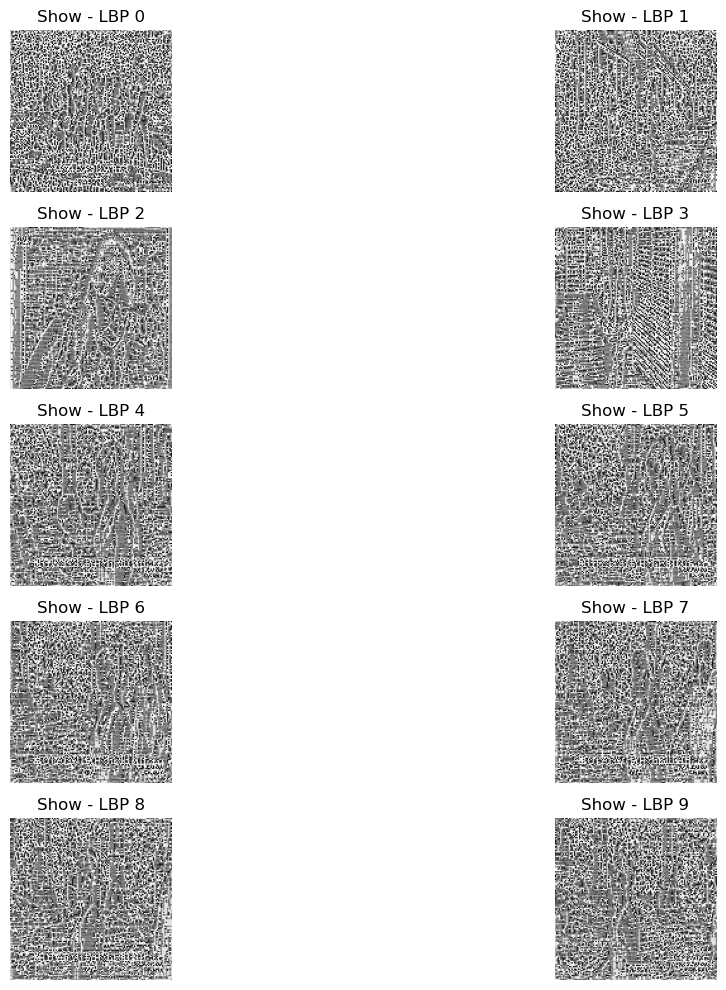

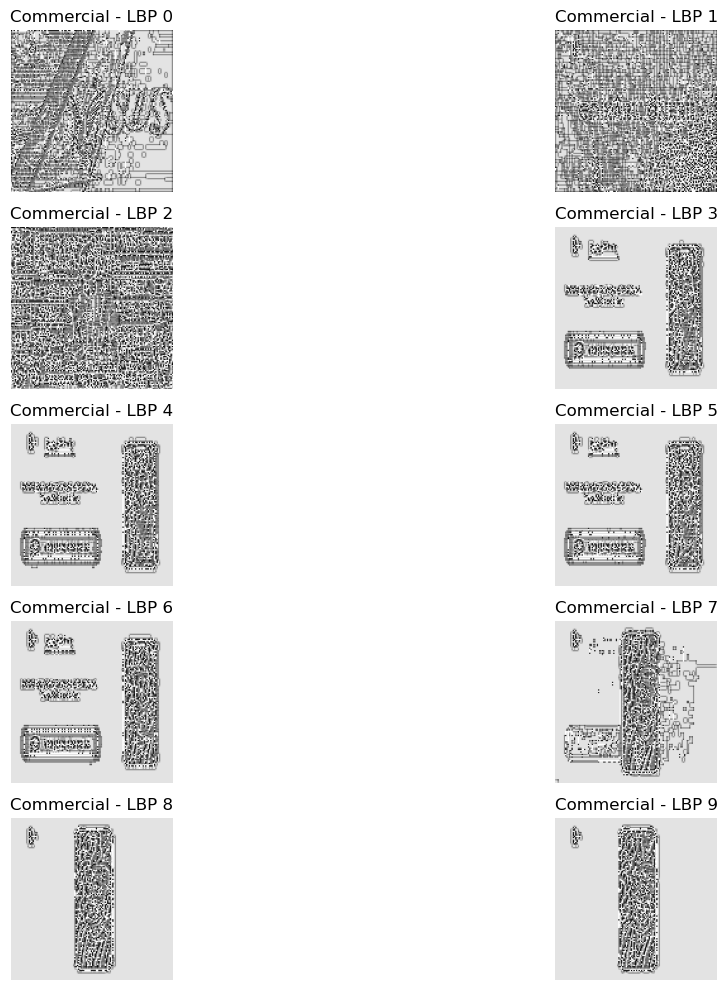

0            1            2            3            4    \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.049322     0.086362     0.038059     0.103695     0.136553   
std       0.023871     0.016992     0.010750     0.014784     0.038540   
min       0.007507     0.036072     0.011292     0.072815     0.075256   
25%       0.029114     0.076157     0.029160     0.093018     0.109375   
50%       0.046173     0.090668     0.041504     0.100311     0.132538   
75%       0.067230     0.100342     0.046387     0.111694     0.158920   
max       0.093933     0.117859     0.057007     0.163818     0.260010   

               5            6            7            8            9    ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.149892     0.087957     0.078852     0.130390     0.138918  ...   
std       0.048921     0.014138     0.015328     0.033037     0.037441  ...   
min       0.085876     0.047180     0.038940     0.072266     0.054626  ...   
25%       0.110016     0.078171     0.068405     0.115601     0.110764  ...   
50%       0.140839     0.083740     0.081726     0.124115     0.136749  ...   
75%       0.180847     0.098145     0.091385     0.134338     0.167068  ...   
max       0.319946     0.137512     0.105652     0.360107     0.205017  ...   

          248     249     250     251     252     253     254     255     256  \
count  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
mean      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
std       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          257  
count  1000.0  
mean      0.0  
std       0.0  
min       0.0  
25%       0.0  
50%       0.0  
75%       0.0  
max       0.0  

[8 rows x 258 columns]

0            1            2            3            4    \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.031906     0.068726     0.026985     0.102591     0.134800   
std       0.016294     0.023376     0.010587     0.026041     0.048658   
min       0.001404     0.005432     0.001404     0.003967     0.002747   
25%       0.020142     0.054657     0.020020     0.092133     0.110687   
50%       0.028809     0.071045     0.027496     0.106293     0.136505   
75%       0.043121     0.084854     0.034729     0.119522     0.163834   
max       0.083008     0.130005     0.056030     0.155884     0.325195   

               5            6            7            8            9    ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.176651     0.081397     0.065368     0.209113     0.102462  ...   
std       0.052358     0.021093     0.017652     0.158097     0.034327  ...   
min       0.011414     0.005676     0.006226     0.067261     0.006592  ...   
25%       0.139938     0.075089     0.054810     0.114594     0.080109  ...   
50%       0.179687     0.086182     0.067078     0.138824     0.105865  ...   
75%       0.207947     0.093094     0.077728     0.251526     0.126724  ...   
max       0.386963     0.134827     0.111389     0.937134     0.204407  ...   

          248     249     250     251     252     253     254     255     256  \
count  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
mean      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
std       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          257  
count  1000.0  
mean      0.0  
std       0.0  
min       0.0  
25%       0.0  
50%       0.0  
75%       0.0  
max       0.0  

[8 rows x 258 columns]

In [30]:
from skimage.feature import local_binary_pattern

# Function to compute LBP
def compute_lbp(images, P=8, R=1):
    lbps = []
    for image in images:
        if image.ndim == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image
        lbp = local_binary_pattern(gray_image, P, R, method='uniform')
        lbps.append(lbp)
    return lbps

# Function to plot LBP images
def plot_lbp(lbps, labels, sample_size=10):
    plt.figure(figsize=(15, 10))
    for i in range(min(sample_size, len(lbps))):
        plt.subplot(sample_size//2, 2, i+1)
        plt.imshow(lbps[i], cmap='gray')
        plt.title(f'{labels} - LBP {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Compute LBP for show and commercial images
show_lbp = compute_lbp(show_sample_images)
commercial_lbp = compute_lbp(commercial_sample_images)

# Plot LBP images for visualization
plot_lbp(show_lbp, 'Show', sample_size=10)
plot_lbp(commercial_lbp, 'Commercial', sample_size=10)

# Function to extract LBP histogram features
def extract_lbp_features(lbps, num_points=8, num_bins=256):
    lbp_features = []
    for lbp in lbps:
        # Compute the histogram of the LBP pattern
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_bins + 3), range=(0, num_bins + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return lbp_features

# Extract LBP histogram features for show and commercial images
show_lbp_features = extract_lbp_features(show_lbp)
commercial_lbp_features = extract_lbp_features(commercial_lbp)

# Convert to DataFrame for better visualization and manipulation
show_lbp_features_df = pd.DataFrame(show_lbp_features)
commercial_lbp_features_df = pd.DataFrame(commercial_lbp_features)

# Display the DataFrame statistics
display(show_lbp_features_df.describe())
display(commercial_lbp_features_df.describe())

# Save the DataFrames to CSV files for further use
show_lbp_features_df.to_csv('show_lbp_features.csv', index=False)
commercial_lbp_features_df.to_csv('commercial_lbp_features.csv', index=False)


In [31]:
import cv2
import numpy as np

def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 8):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5 * kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def extract_gabor_features(images):
    filters = build_filters()
    features = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gabor_response = process(gray_image, filters)
        features.append(gabor_response.flatten())
    return np.array(features)

# Extract Gabor features for show and commercial images
show_gabor_features = extract_gabor_features(show_sample_images)
commercial_gabor_features = extract_gabor_features(commercial_sample_images)

# Convert to DataFrame for better visualization and manipulation
show_gabor_features_df = pd.DataFrame(show_gabor_features)
commercial_gabor_features_df = pd.DataFrame(commercial_gabor_features)

# Display the DataFrame statistics
display(show_gabor_features_df.describe())
display(commercial_gabor_features_df.describe())

# Save the DataFrames to CSV files for further use
show_gabor_features_df.to_csv('show_gabor_features.csv', index=False)
commercial_gabor_features_df.to_csv('commercial_gabor_features.csv', index=False)


0            1            2            3            4      \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     32.459999    30.108999    25.615000    25.233999    28.327000   
std      51.583424    49.366894    43.876354    43.601566    47.605278   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       7.000000     6.000000     0.000000     0.000000     0.000000   
75%      50.000000    44.000000    35.000000    33.250000    40.000000   
max     255.000000   255.000000   255.000000   255.000000   255.000000   

             5            6            7            8            9      ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     31.591999    36.577000    40.664001    40.036999    34.646999  ...   
std      52.083622    59.284653    58.770885    56.452797    48.720901  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     2.000000    11.000000    13.000000    15.000000  ...   
75%      45.250000    51.000000    62.000000    61.000000    53.000000  ...   
max     255.000000   255.000000   255.000000   255.000000   255.000000  ...   

             16374        16375        16376        16377        16378  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     62.508999    57.650002    57.674000    58.632999    58.535000   
std      57.496292    59.086533    59.389927    59.965050    60.829487   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      17.750000     4.000000     5.000000     5.000000     3.500000   
50%      57.000000    50.000000    50.000000    51.000000    51.000000   
75%      83.000000    82.000000    82.000000    83.000000    79.000000   
max     255.000000   255.000000   255.000000   255.000000   255.000000   

             16379        16380        16381        16382        16383  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean     57.424999    55.490002    57.130001    64.279999    67.500000  
std      61.060040    60.017914    60.460304    66.198677    68.621292  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       5.000000     3.750000     6.000000    11.750000    13.750000  
50%      48.000000    47.000000    48.000000    51.000000    52.000000  
75%      75.000000    71.250000    76.000000    85.000000    88.000000  
max     255.000000   255.000000   255.000000   255.000000   255.000000  

[8 rows x 16384 columns]

0            1            2            3            4      \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     56.320000    53.535000    47.063999    43.251999    44.147999   
std      66.023094    63.678989    58.111038    56.804031    59.077038   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000     0.000000   
50%      34.000000    33.000000    29.000000    25.000000    24.000000   
75%      87.000000    84.000000    73.000000    62.000000    60.000000   
max     255.000000   255.000000   255.000000   255.000000   255.000000   

             5            6            7            8            9      ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     46.276001    52.289001    68.030998    72.459000    64.483002  ...   
std      60.813007    60.994503    55.868053    56.110435    59.600609  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000    36.000000    41.000000    20.000000  ...   
50%      24.000000    36.000000    50.000000    56.000000    47.000000  ...   
75%      68.000000    78.000000    89.000000    91.000000    88.000000  ...   
max     255.000000   255.000000   255.000000   255.000000   255.000000  ...   

             16374        16375        16376        16377        16378  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     62.563000    53.091999    48.744999    48.808998    47.698002   
std      58.641323    58.349964    60.075260    61.672359    60.715015   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      12.000000     6.000000     0.000000     0.000000     0.000000   
50%      52.000000    38.500000    31.000000    30.000000    24.000000   
75%      88.000000    77.000000    78.000000    77.000000    75.250000   
max     255.000000   255.000000   255.000000   255.000000   255.000000   

             16379        16380        16381        16382        16383  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean     44.089001    41.049000    42.856998    47.553001    49.903000  
std      59.026119    58.173611    58.732128    61.722450    63.242252  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%      21.000000    18.000000    16.000000    24.000000    26.500000  
75%      65.250000    65.000000    66.000000    76.000000    81.000000  
max     255.000000   255.000000   255.000000   255.000000   255.000000  

[8 rows x 16384 columns]

In [32]:
from skimage.feature import hog
from skimage import color

def extract_hog_features(images):
    hog_features = []
    for image in images:
        gray_image = color.rgb2gray(image)
        hog_feature = hog(gray_image, 
                          orientations=9, 
                          pixels_per_cell=(8, 8), 
                          cells_per_block=(2, 2), 
                          block_norm='L2-Hys', 
                          visualize=False)
        hog_features.append(hog_feature)
    return np.array(hog_features)

# Extract HOG features for show and commercial images
show_hog_features = extract_hog_features(show_sample_images)
commercial_hog_features = extract_hog_features(commercial_sample_images)

# Convert to DataFrame for better visualization and manipulation
show_hog_features_df = pd.DataFrame(show_hog_features)
commercial_hog_features_df = pd.DataFrame(commercial_hog_features)

# Display the DataFrame statistics
display(show_hog_features_df.describe())
display(commercial_hog_features_df.describe())

# Save the DataFrames to CSV files for further use
show_hog_features_df.to_csv('show_hog_features.csv', index=False)
commercial_hog_features_df.to_csv('commercial_hog_features.csv', index=False)


0            1            2            3            4     \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.167536     0.054133     0.043879     0.048760     0.112416   
std       0.089500     0.052987     0.046451     0.051795     0.088016   
min       0.000000     0.000000     0.000000     0.000000     0.000146   
25%       0.088884     0.010486     0.007315     0.007386     0.043879   
50%       0.178387     0.041681     0.028973     0.032392     0.082705   
75%       0.248324     0.082454     0.064719     0.076109     0.169739   
max       0.373433     0.317814     0.271981     0.259334     0.415770   

              5            6            7            8            9     ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.049908     0.048500     0.064853     0.103438     0.183593  ...   
std       0.054638     0.051771     0.062213     0.086739     0.094370  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.006603     0.007586     0.010752     0.028222     0.101777  ...   
50%       0.032002     0.031814     0.047670     0.081383     0.210674  ...   
75%       0.075863     0.072778     0.105809     0.164152     0.259357  ...   
max       0.298987     0.331949     0.281904     0.317965     0.353940  ...   

              8090         8091         8092         8093         8094  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.109596     0.139605     0.044516     0.041222     0.044819   
std       0.096737     0.092098     0.052832     0.053821     0.053401   
min       0.000000     0.003451     0.000000     0.000000     0.000000   
25%       0.029475     0.062945     0.008607     0.005886     0.007246   
50%       0.081046     0.123952     0.026129     0.019670     0.027316   
75%       0.173889     0.211113     0.061724     0.054457     0.062508   
max       0.421787     0.409538     0.320003     0.323518     0.332886   

              8095         8096         8097         8098         8099  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean      0.127066     0.062402     0.053456     0.052142     0.087264  
std       0.114305     0.073488     0.063563     0.059034     0.080856  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.035911     0.008095     0.007148     0.008705     0.026887  
50%       0.090172     0.035245     0.030067     0.031813     0.061538  
75%       0.186553     0.090394     0.077552     0.073517     0.123286  
max       0.495007     0.385059     0.392107     0.300730     0.344568  

[8 rows x 8100 columns]

0            1            2            3            4     \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.109917     0.043452     0.040741     0.031141     0.100759   
std       0.119198     0.075101     0.074228     0.057870     0.101852   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.009803     0.000896     0.000000     0.000000     0.034766   
50%       0.057637     0.005798     0.006241     0.004094     0.049608   
75%       0.203441     0.053139     0.043317     0.033879     0.147507   
max       0.515818     0.358306     0.358306     0.385738     0.398721   

              5            6            7            8            9     ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.029794     0.020363     0.019682     0.055070     0.127064  ...   
std       0.064587     0.046445     0.042915     0.094898     0.124984  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.011767  ...   
50%       0.001244     0.001039     0.001500     0.007034     0.080441  ...   
75%       0.028200     0.015346     0.017980     0.053072     0.257504  ...   
max       0.368698     0.309550     0.309318     0.438803     0.496375  ...   

              8090         8091         8092         8093         8094  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.109502     0.133109     0.051256     0.044222     0.032756   
std       0.107214     0.120652     0.076556     0.063757     0.050844   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.019803     0.028339     0.000067     0.001429     0.000000   
50%       0.080755     0.089653     0.021425     0.018566     0.011652   
75%       0.182323     0.249231     0.061983     0.060860     0.043214   
max       0.577078     0.477934     0.400260     0.400260     0.317150   

              8095         8096         8097         8098         8099  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean      0.116686     0.037115     0.043470     0.042718     0.076117  
std       0.118126     0.063733     0.066889     0.065042     0.096081  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.028541     0.000000     0.000000     0.000000     0.000000  
50%       0.061224     0.008063     0.011731     0.013001     0.033071  
75%       0.196726     0.046036     0.061105     0.057369     0.120333  
max       0.517289     0.357655     0.387572     0.362401     0.517289  

[8 rows x 8100 columns]

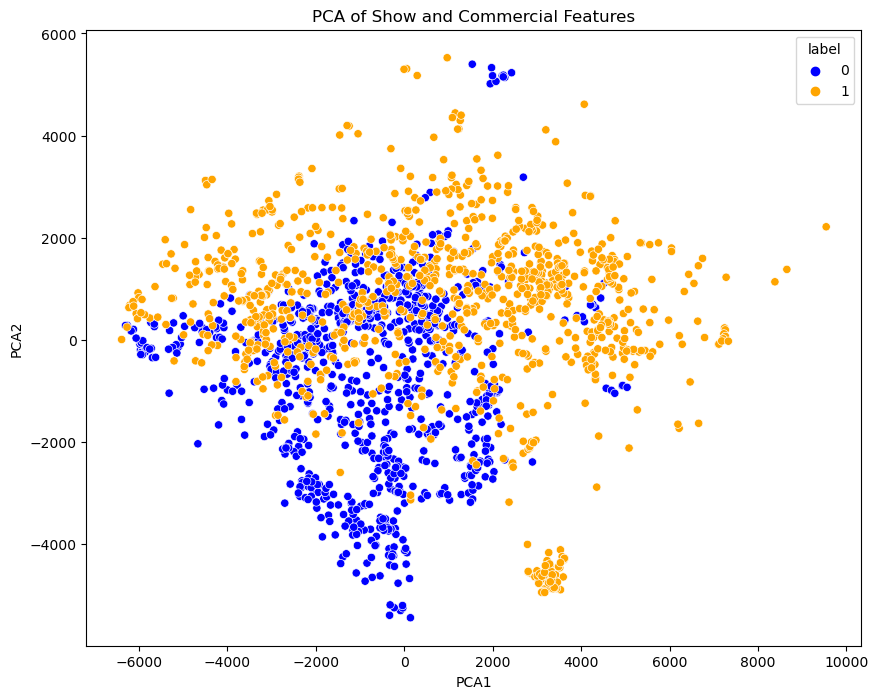

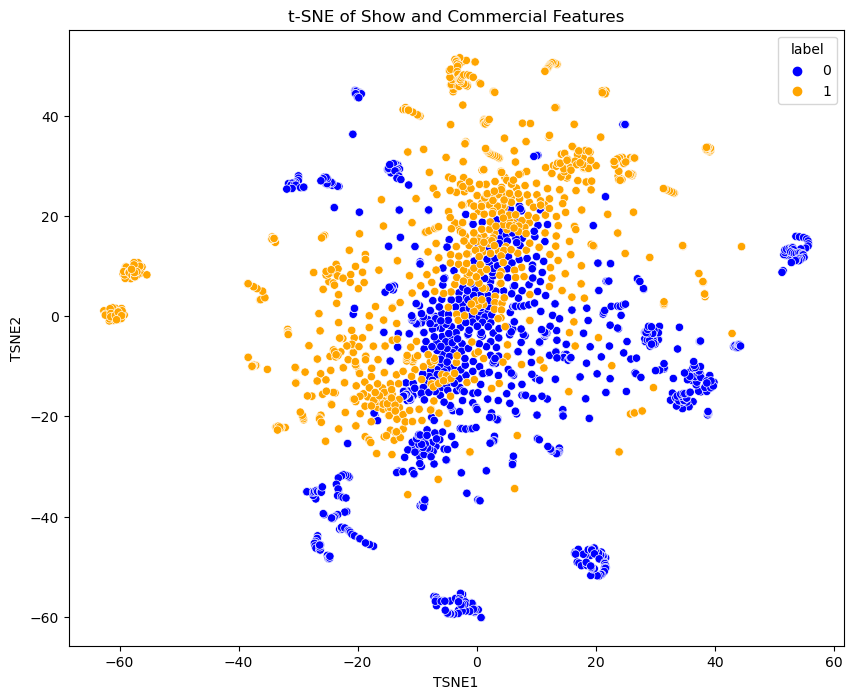

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the extracted features
color_moments_show = pd.read_csv('show_histogram_moments.csv')
color_moments_commercial = pd.read_csv('commercial_histogram_moments.csv')
color_moments = pd.concat([color_moments_show, color_moments_commercial], ignore_index=True)

edge_density_show = pd.read_csv('show_edge_density.csv')
edge_density_commercial = pd.read_csv('commercial_edge_density.csv')
edge_density = pd.concat([edge_density_show, edge_density_commercial], ignore_index=True)

lbp_features_show = pd.read_csv('show_lbp_features.csv')
lbp_features_commercial = pd.read_csv('commercial_lbp_features.csv')
lbp_features = pd.concat([lbp_features_show, lbp_features_commercial], ignore_index=True)

gabor_features_show = pd.read_csv('show_gabor_features.csv')
gabor_features_commercial = pd.read_csv('commercial_gabor_features.csv')
gabor_features = pd.concat([gabor_features_show, gabor_features_commercial], ignore_index=True)

hog_features_show = pd.read_csv('show_hog_features.csv')
hog_features_commercial = pd.read_csv('commercial_hog_features.csv')
hog_features = pd.concat([hog_features_show, hog_features_commercial], ignore_index=True)

# Combine all features into a single dataframe
combined_features = pd.concat([color_moments, edge_density, lbp_features, gabor_features, hog_features], axis=1)

# Add labels (0 for show, 1 for commercial)
labels = [0]*len(color_moments_show) + [1]*len(color_moments_commercial)
combined_features['label'] = labels

# Split the data into training and testing sets
X = combined_features.drop(columns=['label'])
y = combined_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and testing sets
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
